# Processing images

Notebook contain codes to download images, data extraction from .mat files and initial EDA. 

In [26]:
import pandas as pd
from pathlib import Path
from scipy.io import loadmat
from PIL import Image

In [27]:
from fastai import *
from fastai.vision import *

#### Download training set from website

In [ ]:
#download_data('http://imagenet.stanford.edu/internal/car196/cars_train',fname='cars_train', data=True, ext='.tgz')
#!tar -zxvf cars_train.tgz -C datata

In [ ]:
#download_data('http://imagenet.stanford.edu/internal/car196/cars_test',fname='cars_test',ext='.tgz')
#!tar -zxvf cars_test.tgz -C data

In [ ]:
#untar_data('https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz',fname='car_devkit.tgz', dest='data')

#### Download labels for test set 

In [319]:
#!wget http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels.mat
#!mv cars_test_annos_withlabels.mat data/

--2019-06-05 15:42:06--  http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels.mat
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185758 (181K) [text/plain]
Saving to: ‘cars_test_annos_withlabels.mat.1’

cars_test_annos_wit 100%[===================>] 181.40K   134KB/s    in 1.4s    

2019-06-05 15:42:08 (134 KB/s) - ‘cars_test_annos_withlabels.mat.1’ saved [185758/185758]



#### Renaming the folders

In [42]:
#!mv data/cars_train data/train
#!mv data/cars_test data/test

#### Create a unified folder where test images and train images are in for fastai learner to test at the end of training

In [418]:
#!mkdir data/all_img
#!cp -a data/test/. data/all_img    
#cd data/all_img && rename 's/^/test_/' *  # renaming all the test images in the folder with 'test' suffix
#!cp -a data/train/. data/all_img   

In [2]:
train_path = 'data/train/'
cropped_path = 'data/cropped_train/'
test_path = 'data/test/'
all_img_path = 'data/all_img'
test_cropped_path = 'data/cropped_test/'

In [ ]:
CROPPED_PATH = Path(cropped_path)
CROPPED_PATH.mkdir(parents=True, exist_ok=True)

In [6]:
TEST_CROPPED_PATH = Path(test_cropped_path)
TEST_CROPPED_PATH.mkdir(parents=True, exist_ok=True)

Code below is adapted and improved from [Devon from Kaggle](https://www.kaggle.com/criticalmassacre/inaccurate-labels-in-stanford-cars-data-set) and fixed the code to show add all the classes. Thanks!

It is used to extract labels from .mat files 

In [8]:
train_an_pth = 'data/devkit/cars_train_annos.mat'
test_an_pth = 'data/cars_test_annos_withlabels.mat'
classes_pth = 'data/devkit/cars_meta.mat'

def get_labels(annos_path, classes_path):
    car_an = loadmat(annos_path)
    car_meta = loadmat(classes_path)
    annotations = car_an["annotations"][0,:]
    total_classes = len(car_meta["class_names"][0])
    class_names = dict(zip(range(1,total_classes+1),[c[0] for c in car_meta["class_names"][0]]))
    
    labelled_images = {}
    dataset = []
    for arr in annotations:
        # the last entry in the row is the image name
        # The rest is the data, first bbox, then classid
        dataset.append([y[0][0] for y in arr][0:5]+[arr[5][0]])
    # Convert to a DataFrame, and specify the column names
    temp_df = pd.DataFrame(dataset, 
                      columns =['BBOX_X1','BBOX_Y1','BBOX_X2','BBOX_Y2','ClassID','filename'])

    temp_df = temp_df.assign(ClassName=temp_df.ClassID.map(dict(class_names)))
    temp_df.columns = ['bbox_x1','bbox_y1','bbox_x2','bbox_y2','class_id','filename', 'class_name']
    return temp_df

In [15]:
#Creating a train dataframe
train_df = get_labels(train_an_pth, classes_pth)
train_df['test'] = 0 #adding a test column for testing in the future

In [16]:
#Add cropped file names and saving it to csv
train_df['filename_cropped'] = train_df['filename'].map(lambda x: f'cropped_{x}')
#train_df.to_csv('train_labels.csv',index=False)

Generate a csv of for both cropped and normal train images

In [56]:
#train_df_cropped = train_df[['filename_cropped','class_name']].rename(columns={'filename_cropped': 'filename'})
#train_df_norm = train_df[['filename','class_name']]
#train_all = pd.concat([train_df_norm,train_df_cropped])
#train_all.to_csv('train_all.csv', index=False)

In [17]:
#Sanity check
train_df.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,filename,class_name,test,filename_cropped
0,39,116,569,375,14,00001.jpg,Audi TTS Coupe 2012,0,cropped_00001.jpg
1,36,116,868,587,3,00002.jpg,Acura TL Sedan 2012,0,cropped_00002.jpg
2,85,109,601,381,91,00003.jpg,Dodge Dakota Club Cab 2007,0,cropped_00003.jpg
3,621,393,1484,1096,134,00004.jpg,Hyundai Sonata Hybrid Sedan 2012,0,cropped_00004.jpg
4,14,36,133,99,106,00005.jpg,Ford F-450 Super Duty Crew Cab 2012,0,cropped_00005.jpg


In [9]:
#Creating a test dataframe with labels and saving it to csv
test_df = get_labels(test_an_pth,classes_pth)
test_df['test'] = 1

In [8]:
#Sanity check
test_df['filename_cropped'] = test_df['filename'].map(lambda x: f'test_cropped_{x}')
test_df.head()
test_df.to_csv('test_df.csv', index='False')

In [18]:
test_df_all_img = test_df.copy()
test_df_all_img['filename'] = test_df_all_img['filename'].map(lambda x: f'test_{x}')

In [19]:
#Sanity check
test_df_all_img.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,filename,class_name,test,filename_cropped
0,30,52,246,147,181,test_00001.jpg,Suzuki Aerio Sedan 2007,1,test_cropped_00001.jpg
1,100,19,576,203,103,test_00002.jpg,Ferrari 458 Italia Convertible 2012,1,test_cropped_00002.jpg
2,51,105,968,659,145,test_00003.jpg,Jeep Patriot SUV 2012,1,test_cropped_00003.jpg
3,67,84,581,407,187,test_00004.jpg,Toyota Camry Sedan 2012,1,test_cropped_00004.jpg
4,140,151,593,339,185,test_00005.jpg,Tesla Model S Sedan 2012,1,test_cropped_00005.jpg


Creating a unified dataframe that contains both training and test images, for testing after training

In [20]:
all_img_df = pd.concat([train_df,test_df_all_img])
all_img_df = all_img_df.loc[:,['filename', 'class_name', 'class_id', 'test']]
all_img_df.to_csv('all_img.csv',index=False)

In [465]:
#Ensuring class names and class ids are mapped properly 
train_df['class_name'].nunique(), train_df['class_id'].nunique()

(196, 196)

#### Cropping images based on bbox

In [5]:
def _crop(df, path, i):
    img = Image.open(path + df['filename'][i])
    x1 = df['bbox_x1'][i]
    y1 =df['bbox_y1'][i]
    y2 = df['bbox_y2'][i]
    x2 = df['bbox_x2'][i]
    bbox = (x1,y1,x2,y2)
    return img.crop(bbox)

def save(img,df,path,i): 
    return img.save(f'{path + df["filename_cropped"][i]}')
                    
def get_cropped_image(df,path,cropped_path,i):
    cropped = _crop(df,path,i)
    return save(cropped,df,cropped_path,i)
    

Generate cropped images

In [ ]:
#test_df=pd.read_csv('test_df.csv')
#list(map(lambda x: get_cropped_image(test_df,test_path,test_cropped_path,x), list(range(len(test_df)))))
#list(map(lambda x: get_cropped_image(train_df,train_path,train_cropped_path,x), list(range(len(train_df)))))

# EDA

In [23]:
print(f'Number of images in the training set: {len(train_df)}')

Number of images in the training set: 8144


In [33]:
classes_cnt = train_df['class_name'].value_counts()
classes_cnt.describe()

count    196.00000
mean      41.55102
std        4.33382
min       24.00000
25%       39.75000
50%       42.00000
75%       44.00000
max       68.00000
Name: class_name, dtype: float64

With 196 different classes and an average of 41.5 images per class. With a minimum of 24 images and a maximum of 68 images

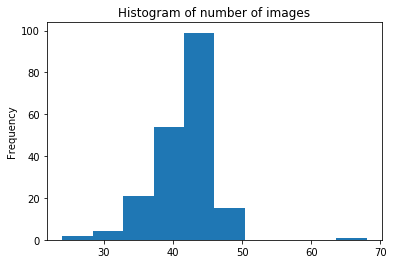

In [24]:
classes_cnt.plot(kind='hist', title='Histogram of number of images')

#### Looking at the aspect ratio of all the images

In [31]:
all_imgs = pd.read_csv('all_img.csv')

In [34]:
src = ImageList.from_df(all_imgs, all_img_path, cols='filename')

In [40]:
lst = []
for i in range(len(src)): 
    lst.append((src[i].size[0],src[i].size[1]))

In [47]:
aspect_ratio = pd.DataFrame(lst, columns=['height','width'])

In [48]:
aspect_ratio['aspect_ratio'] = aspect_ratio['height']/aspect_ratio['width']

In [49]:
aspect_ratio.describe().T

,count,mean,std,min,25%,50%,75%,max
height,16185.0,483.245845,318.311547,41.000000,290.000,426.000,540.00,5400.000000
width,16185.0,700.492555,453.238969,78.000000,429.000,640.000,800.00,7800.000000
aspect_ratio,16185.0,0.692916,0.092752,0.257232,0.659,0.745,0.75,1.686154


Mean aspect ratio for all the images is **0.69** while the median and the 3rd quartile is around **0.75**, it'd be safe to use **0.75** aspect ratio to begin the training. Since Imagenet images are all squared images. 